# Inicializace

In [73]:
from collections import deque               # Ukladani stavu
from __future__ import division             # Deleni realnych cisel (kvuli verzi Pythonu 2.6)
import sys                                  # Pro navazani knihovny Open AI Gym
import numpy as np                          # Knihovna pro operace s maticemi
sys.path.append('/home/xbucha02/libraries') # Adresa knihovny Open AI Gym
import gym                                  # Knihovna Open AI Gym
#from gym import wrappers                    # Pomucka na nahravani
env = gym.make('CartPole-v0')            # Konkretni hra z Open AI Gym
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu
gpuMemoryUsage=1                            # Vyuziti pameti GPU
#import tensorflow as tf                     # Knihovna TensorFlow pro sdileni GPU
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
#set_session(tf.Session(config=config))
import random

# Parametry
observetime = 500                          # Pocet framu kazde hry
startEpsilon = 1                           # Pravdepodobnost konani nahodneho tahu na zacatku
endEpsilon = 0.1                           # Pravdepodobnost konani nahodneho tahu na konci
currentEpsilon = startEpsilon              # Soucasna pravdepodobnost konani nahodneho tahu
epsilonDiminution = 0.995                  # Hodnota snizovani epsilonu
gamma = 0.95                               # Discount faktor
minibatchSize = 32                         # Velikost minibatche
episodes = 500                             # Pocet epizod
actionCount = env.action_space.n           # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0] # Pocet vystupu z prostredi
learningRate = 0.001                       # Learning rate
memorySize = 2000                          # Velikost Replay memory

# Model NN

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

def getDQN(actionCount,stateSize):
    net = Sequential()
    net.add(Dense(24, activation="relu", input_dim=stateSize))
    net.add(Dense(24, activation="relu"))
    net.add(Dense(actionCount, activation="linear"))
    
    net.summary()
    
    net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    
    return net

# Algoritmus DQN

In [75]:
net = getDQN(actionCount, stateSize)
observation = env.reset()                    # Reset prostredi
memory = deque(maxlen=memorySize)

global scores
scores = []
global episodes
episodesList = []

for eps in range (episodes):
    
    #D = deque() #vyprazdneni D
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    #env.render()

    #q = 0
    for t in range(observetime):
        #if q == 0:
            
        #else:
        #    if q == 4:
        #        q = 0
        #    else:
        #        q = q + 1
        if np.random.rand() <= currentEpsilon:
            action = np.random.randint(0, actionCount, size=1)[0]
        else:

            Q = net.predict(state)

            action = np.argmax(Q)

        observation_new, reward, done, info = env.step(int(action))

        next_state = np.reshape(observation_new, [1, stateSize])

        memory.append((state, action, reward, next_state, done))

        state = next_state         # Update state

        if done:
            print("Episode: {}/{}, epsilon: {}, score: {}".format(eps, episodes, currentEpsilon, t))
            scores.append(t)
            episodesList.append(eps)
            break
            
    if eps > 0:
        if len(memory) < minibatchSize:
            continue
        minibatch = random.sample(memory, minibatchSize) #z D vybere pocet mb_size samplu

        for i in range(0, minibatchSize):

            stateMb = minibatch[i][0]
            actionMb = minibatch[i][1]
            rewardMb = minibatch[i][2]
            state_newMb = minibatch[i][3]
            doneMb = minibatch[i][4]

            Q_sa = net.predict(state_newMb)#[0]

            if doneMb:
                targetMb = rewardMb
            else:
                targetMb = rewardMb + gamma * np.max(Q_sa)

            target_f = net.predict(stateMb)

            target_f[0][actionMb] = targetMb


            net.fit(stateMb, target_f, epochs=1, verbose=0)

        if currentEpsilon > endEpsilon:
            currentEpsilon = currentEpsilon * epsilonDiminution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_41 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 50        
Total params: 770.0
Trainable params: 770
Non-trainable params: 0.0
_________________________________________________________________
Episode: 0/500, epsilon: 1, score: 13
Episode: 1/500, epsilon: 1, score: 10
Episode: 2/500, epsilon: 1, score: 19
Episode: 3/500, epsilon: 0.995, score: 15
Episode: 4/500, epsilon: 0.990025, score: 12
Episode: 5/500, epsilon: 0.985074875, score: 17
Episode: 6/500, epsilon: 0.9801495006250001, score: 25
Episode: 7/500, epsilon: 0.9752487531218751, score: 18
Episode: 8/500, epsilon: 0.9703725093562657, 

Episode: 135/500, epsilon: 0.5134164023722473, score: 8
Episode: 136/500, epsilon: 0.510849320360386, score: 15
Episode: 137/500, epsilon: 0.5082950737585841, score: 16
Episode: 138/500, epsilon: 0.5057535983897912, score: 10
Episode: 139/500, epsilon: 0.5032248303978422, score: 9
Episode: 140/500, epsilon: 0.500708706245853, score: 14
Episode: 141/500, epsilon: 0.4982051627146237, score: 10
Episode: 142/500, epsilon: 0.49571413690105054, score: 11
Episode: 143/500, epsilon: 0.4932355662165453, score: 16
Episode: 144/500, epsilon: 0.4907693883854626, score: 9
Episode: 145/500, epsilon: 0.4883155414435353, score: 8
Episode: 146/500, epsilon: 0.4858739637363176, score: 18
Episode: 147/500, epsilon: 0.483444593917636, score: 14
Episode: 148/500, epsilon: 0.4810273709480478, score: 11
Episode: 149/500, epsilon: 0.47862223409330756, score: 10
Episode: 150/500, epsilon: 0.47622912292284103, score: 10
Episode: 151/500, epsilon: 0.4738479773082268, score: 10
Episode: 152/500, epsilon: 0.471478

Episode: 278/500, epsilon: 0.2507092085103961, score: 54
Episode: 279/500, epsilon: 0.2494556624678441, score: 70
Episode: 280/500, epsilon: 0.24820838415550486, score: 199
Episode: 281/500, epsilon: 0.24696734223472733, score: 61
Episode: 282/500, epsilon: 0.2457325055235537, score: 118
Episode: 283/500, epsilon: 0.24450384299593592, score: 46
Episode: 284/500, epsilon: 0.24328132378095624, score: 66
Episode: 285/500, epsilon: 0.24206491716205145, score: 151
Episode: 286/500, epsilon: 0.2408545925762412, score: 48
Episode: 287/500, epsilon: 0.23965031961336, score: 67
Episode: 288/500, epsilon: 0.2384520680152932, score: 108
Episode: 289/500, epsilon: 0.23725980767521673, score: 88
Episode: 290/500, epsilon: 0.23607350863684065, score: 41
Episode: 291/500, epsilon: 0.23489314109365644, score: 55
Episode: 292/500, epsilon: 0.23371867538818816, score: 66
Episode: 293/500, epsilon: 0.23255008201124722, score: 79
Episode: 294/500, epsilon: 0.231387331601191, score: 37
Episode: 295/500, ep

Episode: 420/500, epsilon: 0.12304040492325048, score: 199
Episode: 421/500, epsilon: 0.12242520289863423, score: 20
Episode: 422/500, epsilon: 0.12181307688414106, score: 46
Episode: 423/500, epsilon: 0.12120401149972035, score: 73
Episode: 424/500, epsilon: 0.12059799144222175, score: 79
Episode: 425/500, epsilon: 0.11999500148501063, score: 199
Episode: 426/500, epsilon: 0.11939502647758558, score: 94
Episode: 427/500, epsilon: 0.11879805134519765, score: 99
Episode: 428/500, epsilon: 0.11820406108847166, score: 96
Episode: 429/500, epsilon: 0.1176130407830293, score: 199
Episode: 430/500, epsilon: 0.11702497557911415, score: 102
Episode: 431/500, epsilon: 0.11643985070121858, score: 146
Episode: 432/500, epsilon: 0.11585765144771248, score: 107
Episode: 433/500, epsilon: 0.11527836319047392, score: 167
Episode: 434/500, epsilon: 0.11470197137452155, score: 116
Episode: 435/500, epsilon: 0.11412846151764894, score: 115
Episode: 436/500, epsilon: 0.1135578192100607, score: 161
Episod

# Výsledky

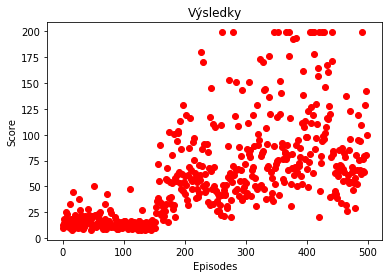

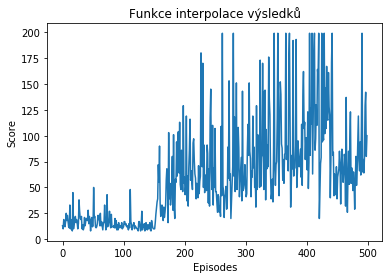

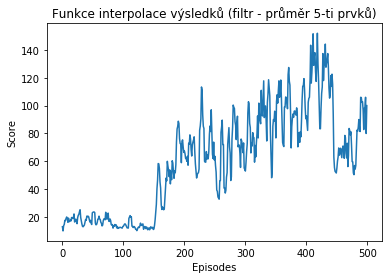

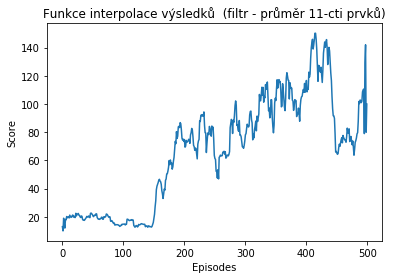

In [76]:
%matplotlib inline  
import matplotlib.pyplot as plt
import copy

score1 = copy.copy(scores)
score2 = copy.copy(scores)

for i in range (len(scores)):
    if i > 1 and i < 498:
        score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5
        
for i in range (len(scores)):
    if i > 4 and i < 495:
        score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
        score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
        score2[i] = score2[i]/10
        
plt.plot(episodesList, scores, 'ro')
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Výsledky")
plt.show()

plt.plot(scores)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků")
plt.show()

plt.plot(score1)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků (filtr - průměr 5-ti prvků)")
plt.show()

plt.plot(score2)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků  (filtr - průměr 11-cti prvků)")
plt.show()